## Map plots

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as ss
import matplotlib.pyplot as plt
import xarray as xr
import os
from collections import OrderedDict
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from itertools import cycle
import gsw
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely import geometry
import cmocean
import cmocean.cm as cmo

# some colors 
color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'

lightthermal = cmocean.tools.crop_by_percent(cmo.thermal, 5, which='min', N=None)

#matplotlib.get_configdir()
plt.style.use('/Users/North/.matplotlib/manuscript.mplstyle')

T_range = np.array((15,18))
S_range = np.array((35.,35.6))
N_range = np.array((-5,-3))
sigma_range = np.array((24.2,27.2))
sigma_levels = np.arange(sigma_range[0]-0.2,sigma_range[1]+.2,0.05)
U_range = np.array((-0.5,0.5))

t_range = ('2016-11-17T00:00:00','2016-12-08T04:00:00')
t_slice = slice(t_range[0],t_range[1])
z_sel, new_grid_size = -17, 100 

os.chdir("/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela") # need to set working directory to get .nc file access
sadcp_nc_dir = './netcdf_files/'
figure_dir = './figures/paper/'


In [2]:
def read_in_scan_sadcp(transect_name):
    # actually just sadcp data, but putting them in same Dict
    scan_sadcp_transects_xkm = xr.open_dataset((sadcp_nc_dir+'scan_sadcp_transects_1km_'+transect_name+'.nc')) 
    scan_sadcp_transects_xkm = scan_sadcp_transects_xkm.set_index(xy=['x_m','lat','lon','time','time_secs'])
    return scan_sadcp_transects_xkm
def read_in_sadcp(transect_name):
    # actually just sadcp data, but putting them in same Dict
    sadcp_transects_xkm = xr.open_dataset((sadcp_nc_dir+'sadcp_transects_1km_'+transect_name+'.nc')) 
    sadcp_transects_xkm = sadcp_transects_xkm.set_index(xy=['x_m','lat','lon','time','time_secs'])
    return sadcp_transects_xkm

def setup_cartopy_ticks(ax,projection=ccrs.PlateCarree(),xtick_diff=1,ytick_diff=-1):
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    # setup ticks
    ax.set_xticks(np.arange(-90,90,xtick_diff), crs=projection)
    ax.set_yticks(np.arange(0,-80,ytick_diff), crs=projection)
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                       dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    return ax

def plot_drifters(drifter_ds,drifter_slice,ndays,ax,line_color):
    sel_time = slice(drifter_ds.isel(drifter=drifter_slice).time[0].values,
                     drifter_ds.isel(drifter=drifter_slice).time[0].values  + np.timedelta64(ndays, 'D') )
    drifter_ds.set_coords(['lon']).lat.sel(time=sel_time).isel(drifter=drifter_slice).plot.line(x='lon',hue='drifter',lw = 1, 
                                                                                                alpha=1, color=line_color,add_legend=False,
                                                                                                ax = ax)
    for di in drifter_ds.drifter.isel(drifter=drifter_slice).values:
        drifter_ds.sel(drifter=di).dropna('time',how='all').isel(time=0).plot.scatter(x='lon',y='lat',lw = 1, color=line_color,
                                                                                       edgecolors = 'k',
                                                                                           add_guide=False, ax = ax)
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')

def text_w_outline(x,y,letter,ax):
    import matplotlib.patheffects as PathEffects
    txt = plt.text(x,y,letter,horizontalalignment='right',verticalalignment='bottom',transform=ax.transAxes,fontsize=24)     
    txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])

def label_axes(fig, labels=None, loc=None, **kwargs):
    """
    rpn: copied on 25.9.2010 from: https://gist.github.com/tacaswell/9643166
    Walks through axes and labels each.
    kwargs are collected and passed to `annotate`
    Parameters
    ----------
    fig : Figure
         Figure object to work on
    labels : iterable or None
        iterable of strings to use to label the axes.
        If None, lower case letters are used.
    loc : len=2 tuple of floats
        Where to put the label in axes-fraction units
    """
    if labels is None:
        labels = string.ascii_lowercase
        
    # re-use labels rather than stop labeling
    labels = cycle(labels)
    if loc is None:
        loc = (.9, .9)
    for ax, lab in zip(fig.axes, labels):
        ax.annotate(lab, xy=loc,
                    xycoords='axes fraction',
                    **kwargs)

In [3]:
# ====== Load in data

# ====== sadcp for full cruise ship track
sadcp = xr.open_dataset(sadcp_nc_dir+'sadcp_1km.nc')

# ====== load SADCP data for transects used for spectral analysis
sadcp_transects_1km = OrderedDict() # Preallocate output dictionary
sadcp_transects_1km['WestwardFromUpwellTransect1'] = read_in_sadcp('WestwardFromUpwellTransect1').reset_index('xy').swap_dims({'xy':'x_m'})
sadcp_transects_1km['ToCapetown1'] = read_in_sadcp('ToCapetown1').reset_index('xy').swap_dims({'xy':'x_m'})
sadcp_transects_1km['AwayFromFilament1'] = read_in_sadcp('AwayFromFilament1').reset_index('xy').swap_dims({'xy':'x_m'})
sadcp_transects_1km['FullScanTransect1'] = read_in_sadcp('FullScanTransect1').reset_index('xy').swap_dims({'xy':'x_m'})
for key in sadcp_transects_1km:
    # for nicer plotting, create x-coordinate in km
    sadcp_transects_1km[key] = (sadcp_transects_1km[key].
                                          assign_coords(x_km=sadcp_transects_1km[key].x_m/1e3))

# ====== load SADCP and Scanfish data for transects that cross filament
# cut ScanTransect to focus on filament
scan_sadcp_transects_1km_filament = OrderedDict() # Preallocate output dictionary
scan_sadcp_transects_1km_filament['ScanTransect1'] = (read_in_scan_sadcp('ScanTransect1').reset_index('xy').swap_dims({'xy':'x_m'}).
                                                      sel(x_m=slice(12e3,65.5e3)))
scan_sadcp_transects_1km_filament['ScanTransect1'] = scan_sadcp_transects_1km_filament['ScanTransect1'].assign_coords(
    x_m=scan_sadcp_transects_1km_filament['ScanTransect1'].x_m-scan_sadcp_transects_1km_filament['ScanTransect1'].x_m[0])
scan_sadcp_transects_1km_filament['ScanTransect2'] = (read_in_scan_sadcp('ScanTransect2').reset_index('xy').swap_dims({'xy':'x_m'}).
                                                      sel(x_m=slice(9.5e3,100.5e3)))
scan_sadcp_transects_1km_filament['ScanTransect2'] = scan_sadcp_transects_1km_filament['ScanTransect2'].assign_coords(
    x_m=scan_sadcp_transects_1km_filament['ScanTransect2'].x_m-scan_sadcp_transects_1km_filament['ScanTransect2'].x_m[0])

# ====== load SST map
# sst map as xr.dataset
sst_sel_file = '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/netcdf_files/sst_aqua_day.nc'
sst_map_ds = xr.open_dataset(sst_sel_file)
 
# ====== load SSH map
gos_map = xr.open_dataset(sadcp_nc_dir+'sla_gos.nc')

# ======  full drifter data set
drifter_ds = xr.open_dataset(sadcp_nc_dir+'drifter_Dataset.nc')
# Ro estimated for drifters
drifter_Ro = xr.open_dataset(sadcp_nc_dir+'drifter_clusters_Ro_Div_Release1_2.nc')

# *** cleaning up drifter data
def replace_outliers(data, dim='time', perc=0.99):
    # calculate percentile 
    threshold = data.quantile(perc,dim=dim)
    # find outliers and replace them with nan
    mask = xr.where((data <= threshold) & (data >= -threshold),data,np.nan)
    return mask

drifter_Ro_clean = drifter_Ro.set_coords(['lat','lon','lat_res','lon_res'])
drifter_Ro_clean_sel = replace_outliers(drifter_Ro_clean[['RossbyNumber','Divergence']], dim='time', perc=0.99)
drifter_Ro_clean['RossbyNumber'] = drifter_Ro_clean_sel.RossbyNumber
drifter_Ro_clean['Divergence'] = drifter_Ro_clean_sel.Divergence


/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


In [4]:
# ==== Ro Kriging with ADCP data
# 2D Ordinary kriging
# - using  PyKrige, kriging toolkit for Python: geostat-framework.readthedocs.io/projects/pykrige
# Tuning (from another Jupyter Notebook):
# - to tune the parameters for Orginary kriging of u and v, used rk.Krige: A scikit-learn wrapper class for Ordinary and Universal Kriging
# - A scikit-learn compatible API for parameter tuning by cross-validation is exposed in sklearn.model_selection.GridSearchCV.
# - GridSearchCV: Exhaustive search over specified parameter values for an estimator.
#  - output from GridSearchCV focused on best R^2 and reducing standard deviation: 
# https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/examples/08_krige_cv.html#sphx-glr-examples-08-krige-cv-py
# - split into training and testing data sets, but actually only used training for tuning
# - used ordinary kriging method, and tested variogram model, number of closest points, nlags and weigthing
# - but mostly compared variogram model and ADCP data time intervals (0.25, 0.5 hours) and data setup: data from just the 
# transects (ie after cutting them out) vs full cruise data vs full cruise data after removing times when ship speed was 
# below a threshold (1.5, 2.1, 3.)
# Results:
# - although transects give best R^2, they leave many holes
# - best of both worlds: use ADCP data from full cruise track, with data removed when ship speed below 2.1 m/s 
# - reducing dt to 0.25 hours doesn't provide a big improvement over 0.5H, but is much slower

def get_gridded(var_in,var_name,best_params):
    from pykrige.ok import OrdinaryKriging
    OK = OrdinaryKriging(
        var_in.lon.values,
        var_in.lat.values,
        var_in[var_name].values,
        variogram_model=best_params['variogram_model'],
        verbose=False,
        enable_plotting=False,
        enable_statistics=False,
        coordinates_type="geographic",
        weight=best_params['weight'],
        nlags=best_params['nlags']
    )

    # Execute on grid:
    grid_var, ss1 = OK.execute("grid", grid_lon, grid_lat,n_closest_points=best_params['n_closest_points'])
    
    xr_gpr = xr.Dataset({var_name: (['lat','lon'],  grid_var),
                         (var_name+'_std'): (['lat','lon'],ss1)},
                        coords={'lon':(grid_lon),'lat':(grid_lat)})
    return xr_gpr

def Ro_from_krig(sadcp_gpr_sel):    
    # calc Ro from ADCP kriging output
    x_m = np.append(0,np.cumsum(gsw.geostrophy.distance(sadcp_gpr_sel.lon.values, 
                                                        np.ones(sadcp_gpr_sel.lon.shape)*sadcp_gpr_sel.lat[0].values,p=0, axis=0)))
    y_m = np.append(0,np.cumsum(gsw.geostrophy.distance(np.ones(sadcp_gpr_sel.lat.shape)*sadcp_gpr_sel.lat[0].values, 
                                                        sadcp_gpr_sel.lat.values,p=0, axis=0)))
    # need distances for vorticity calc
    sadcp_gpr_sel = sadcp_gpr_sel.assign_coords(x_m=("lon", x_m))#(x_m=lambda sadcp_gpr_sel: sadcp_gpr_sel.lon * 0+x_m)
    sadcp_gpr_sel = sadcp_gpr_sel.assign_coords(y_m=("lat", y_m))#(y_m=lambda sadcp_gpr_sel: sadcp_gpr_sel.lon * 0+y_m)

    # vertical vort = dv/dx - du/dy
    sadcp_gpr_sel['rel_vort'] = (sadcp_gpr_sel.v.diff('lon')/sadcp_gpr_sel.x_m.diff('lon') - 
                                 sadcp_gpr_sel.u.diff('lat')/sadcp_gpr_sel.y_m.diff('lat'))
    # Coriolis parameter
    earth_rot = 7.2921*10**-5 # rotation rate of the earth rad/s
    lat_mean = sadcp_gpr_sel.lat.mean() # latitude degrees
    sadcp_gpr_sel['fo'] = 2*earth_rot*np.sin(lat_mean*np.pi/180) # coriolis parameter for given latitude s^-1
    sadcp_gpr_sel['Ro'] = sadcp_gpr_sel['rel_vort']/sadcp_gpr_sel.fo
    
    return sadcp_gpr_sel

# only when the ship is going faster than 2.1 m/s
vel_ship = (sadcp.uship**2+sadcp.vship**2)**0.5
sadcp_minVel = sadcp.where(vel_ship>2.1).sortby('time').interpolate_na('time')

# data based on optimization in 16.Rossby_Number...
var_in = sadcp_minVel.sel(time=t_slice).sel(z=z_sel,method='nearest').resample(time='0.5H').mean('time')

# Input space
grid_lon = np.linspace(var_in.lon.min().values, var_in.lon.max().values, new_grid_size)
grid_lat = np.linspace(var_in.lat.min().values, var_in.lat.max().values, new_grid_size)
grid_lon_lat = (np.array([grid_lon, grid_lat])).T

# kriging u and v velocities onto a grid
u_best_params =  {'method': 'ordinary', 'n_closest_points': None, 'nlags': 6, 'variogram_model': 'spherical', 'weight': True}
v_best_params =  u_best_params #{'method': 'ordinary', 'n_closest_points': 20, 'nlags': 8, 'variogram_model': 'spherical', 'weight': False}
sadcp_krig = xr.merge([get_gridded(var_in,'u',u_best_params),get_gridded(var_in,'v',v_best_params)])

# Ro from ADCP based on krigged u,v velocities
sadcp_krig = Ro_from_krig(sadcp_krig).rename({'lon':'lon_left','lat':'lat_left'})


In [5]:
# ==== combine Ro maps for easier plotting; use ADCP data nearest to surface
Ro_gos = xr.concat((gos_map.Ro.sel(time='2016-11-18'),gos_map.Ro.sel(time='2016-11-25'),gos_map.Ro.sel(time='2016-12-01')),
                   dim='time').sortby('lon_left')
Ro_krig = sadcp_krig.Ro.assign_coords({'time':gos_map.time[2]}) # add date so they concat; use 11-18 as it is Scanfish1 transect
# add another sadcp_krig to overlay drifters
Ro_krig_copy = sadcp_krig.Ro.assign_coords({'time':gos_map.time[-2]}) # add random date so they can concat
# difference between middle Ro_gos and Ro_krig
#Ro_diff = (Ro_krig.interp_like(Ro_gos.sel(lat_left=slice(-40,-20),lon_left=slice(5,20)))-
#                      Ro_gos.sel(lat_left=slice(-40,-20),lon_left=slice(5,20)).isel(time=1))
Ro_diff = Ro_krig - Ro_gos.sel(lat_left=slice(-40,-20),lon_left=slice(5,20)).isel(time=1).interp_like(Ro_krig) 

Ro_diff = Ro_diff.assign_coords({'time':gos_map.time[-1]}) # add random date so they can concat

Ro_all = xr.concat((Ro_gos.sel(lat_left=slice(-40,-20),lon_left=slice(5,20)),
                    Ro_krig.interp_like(Ro_gos.sel(lat_left=slice(-40,-20),lon_left=slice(5,20))),
                    Ro_krig_copy.interp_like(Ro_gos.sel(lat_left=slice(-40,-20),lon_left=slice(5,20))),
                    Ro_diff.interp_like(Ro_gos.sel(lat_left=slice(-40,-20),lon_left=slice(5,20)))),
                   dim='time')

#####    1. Map of study area, cruise track, and drifter tracks

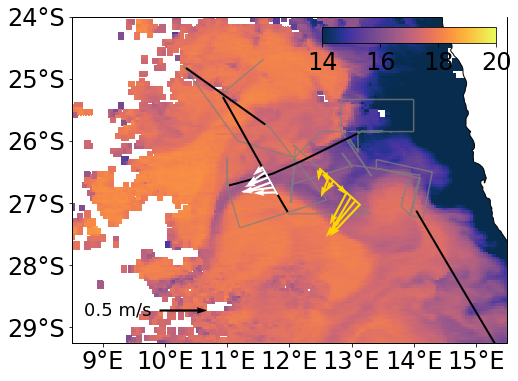

In [6]:
drifter_slice = slice(0,36) # which drifters to plot
    
# setting up figure and subplots
nrows, ncols =  1,1
projection = ccrs.PlateCarree()
x_y_lim = [8.5,15.5,-24.,-29.25]
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*8.,nrows*6),subplot_kw=dict(projection=projection))

stime = '2016-11-18' # which sst map to use
do = 35 # how long to make drifter tracks
# plotting sst map 
p1 = sst_map_ds.sel(Date=stime,method='nearest').sst.plot(transform=projection, vmin=14,vmax=20,cmap=lightthermal, 
                                                      robust=True,add_colorbar=False,ax=axs)
axs=setup_cartopy_ticks(axs)  # nice axis tick labels 
axs.set_extent(x_y_lim, projection)  # x,y limits
# adding shoreline feature
dataset = cfeature.NaturalEarthFeature(category='physical', name='land', scale='10m')
axs.add_feature(dataset, zorder=100, edgecolor='k',facecolor='w')#cfeature.COLORS['land'])
axs.set_title('')
axs.set_xlabel('')

# add section transects, and velocity vectors near surface
tran1 = scan_sadcp_transects_1km_filament['ScanTransect1'] # just to make code lines a bit shorter
tran1.lat.plot(x='lon',lw = 2, color='w', transform=projection,ax=axs,zorder=100)
skip, z_ind = 10, -20
sadcp_plt = axs.quiver(tran1.lon.dropna('x_m')[::skip].values, tran1.lat.dropna('x_m')[::skip].values, 
                          tran1.u.sel(z=z_ind,method='nearest').dropna('x_m')[::skip].values,
                          tran1.v.sel(z=z_ind,method='nearest').dropna('x_m')[::skip].values,
                          color='w', transform=projection,zorder=100,width=0.005)

tran1 = scan_sadcp_transects_1km_filament['ScanTransect2']
tran1.lat.plot(x='lon',lw = 2, color=color4, transform=projection,ax=axs,zorder=100)
sadcp_plt = axs.quiver(tran1.lon.dropna('x_m')[::skip].values, tran1.lat.dropna('x_m')[::skip].values, 
                          tran1.u.sel(z=z_ind,method='nearest').dropna('x_m')[::skip].values,
                          tran1.v.sel(z=z_ind,method='nearest').dropna('x_m')[::skip].values,
                          color=color4, transform=projection,zorder=100,width=0.005)
# make quiver key
qk = plt.quiverkey(sadcp_plt, 0.2, 0.1, 0.5, '0.5 m/s', labelpos='W', color='k',fontproperties={'size':18})
# add colorbar for SST map
cbaxes = inset_axes(axs, width="40%", height="5%", loc=1) 
plt.colorbar(p1, cax=cbaxes, orientation='horizontal', ticks=np.linspace(14,20,4))

# show ship track
(sadcp.sel(z=z_sel,method='nearest').sel(time=t_slice).set_coords(['lon']).lat.plot(x='lon',color='0.5',lw=1.5,alpha=0.75,
                                                                                    ax=axs, transform=projection))
# show drifter tracks
# plot_drifters(drifter_ds, drifter_slice, do-21,axs,color2) # drifters[key].time[0].values = 11.21
axs.set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

# add spectra transects as thick lines
tran1 = sadcp_transects_1km['WestwardFromUpwellTransect1']
tran1.lat.plot(x='lon',lw = 2, color='k', transform=projection,ax=axs)
tran1 = sadcp_transects_1km['ToCapetown1']
tran1.lat.plot(x='lon',lw = 2, color='k', transform=projection,ax=axs)
tran1 = sadcp_transects_1km['AwayFromFilament1']
tran1.lat.plot(x='lon',lw = 2, color='k', transform=projection,ax=axs)
tran1 = sadcp_transects_1km['FullScanTransect1']
tran1.lat.plot(x='lon',lw = 2, color='k', transform=projection,ax=axs)

axs.set_xlabel('')
axs.set_ylabel('')

figname = figure_dir+'Figure_region_map_SST.pdf'
fig.savefig(figname, orientation='landscape', bbox_inches='tight')


#####    2. Filament formation


/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/ipykernel_launcher.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/ipykernel_launcher.py:98: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


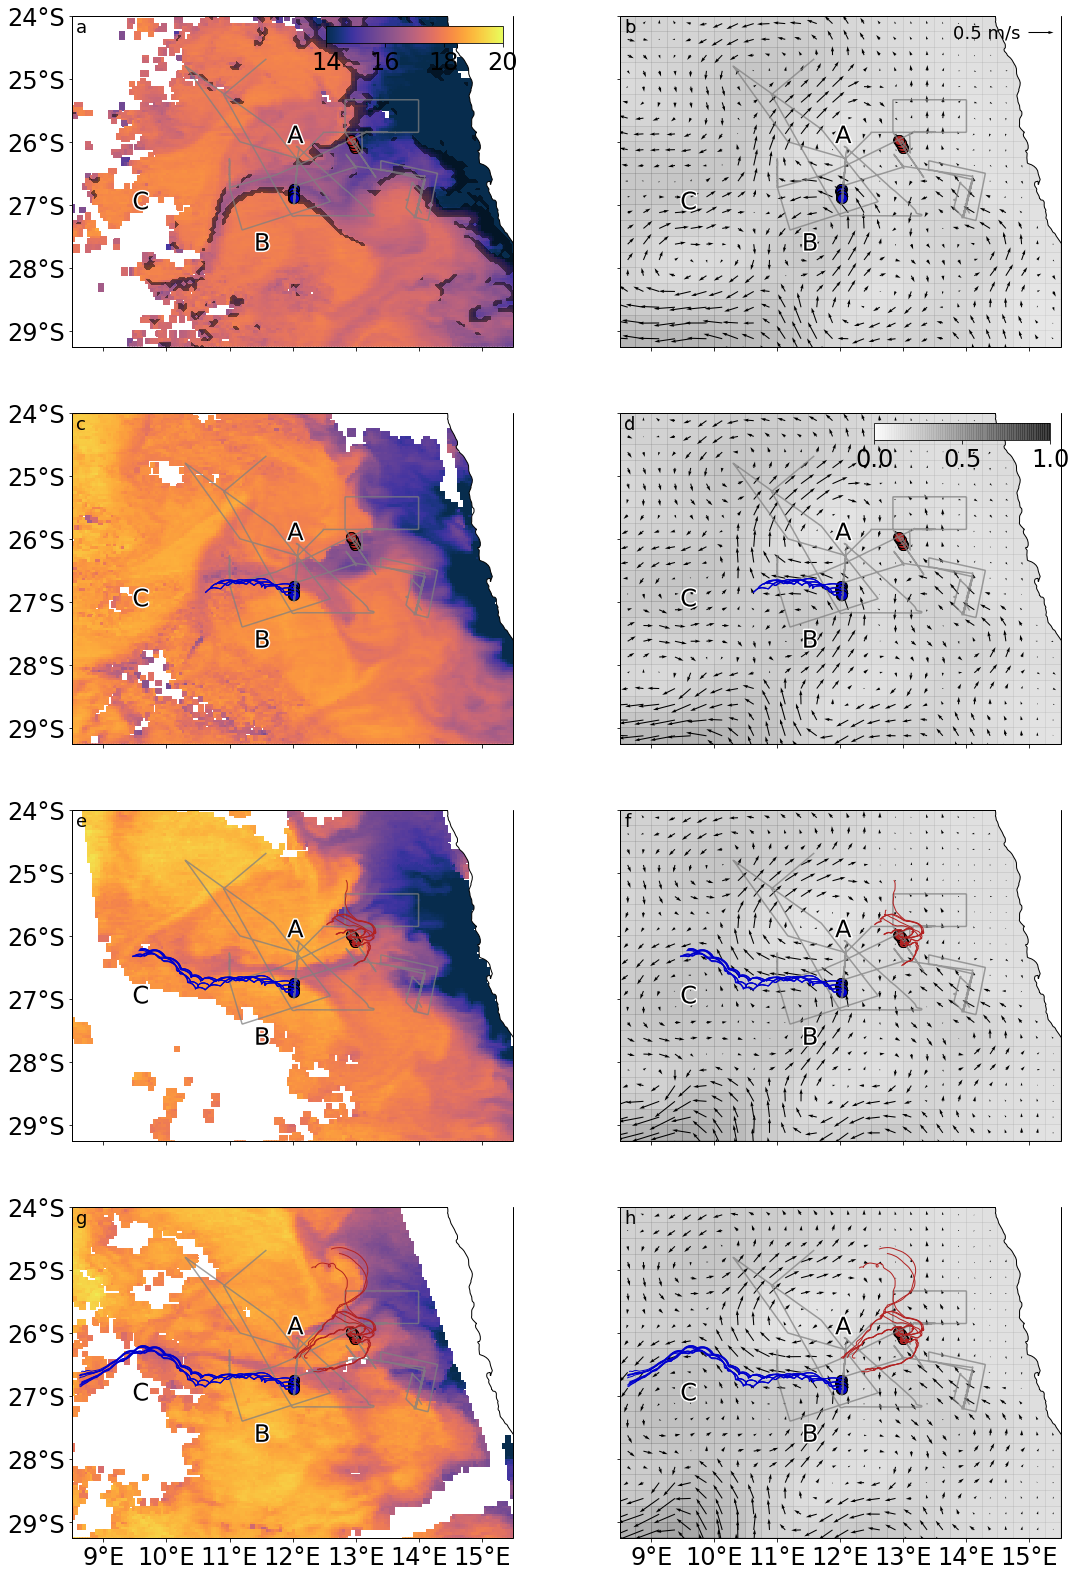

In [16]:
drifter_slice = slice(0,12) # drifters to plot
drifter_slice_north=slice(12,23)
sst_times = np.array(('2016-11-18','2016-11-25','2016-12-01','2016-12-05')) # sst maps to use
    
nrows, ncols =  4,2
projection = ccrs.PlateCarree()
x_y_lim = [8.5,15.5,-24.,-29.25]
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*9.,nrows*7),subplot_kw=dict(projection=projection))
axs = axs.ravel()

si = 0
drift_offset = np.array((21,25,31,35)) # how many days of drifter data to plot
# loop through SST maps and matching drifter track lengths
for stime,do in zip(sst_times,drift_offset): 
    p1 = sst_map_ds.sel(Date=stime,method='nearest').sst.plot(transform=projection, vmin=14,vmax=20,cmap=lightthermal, 
                                                          robust=True,add_colorbar=False,ax=axs[si])
    axs[si]=setup_cartopy_ticks(axs[si])
    axs[si].set_extent(x_y_lim, projection)
    dataset = cfeature.NaturalEarthFeature(category='physical', name='land', scale='10m')
    axs[si].add_feature(dataset, zorder=100, edgecolor='k',facecolor='w')#cfeature.COLORS['land'])
    axs[si].set_title('')
    axs[si].set_xlabel('')
    if si < 6:
        axs[si].set_xticklabels([])

    if si == 0: 
        # add horizontal SST gradient as shading; need to put it on a grid first
        hgrad = np.gradient(sst_map_ds.sel(Date=stime,method='nearest').sst.values,2,2)
        sst_grad = (sst_map_ds.sel(Date=stime,method='nearest').sst.copy(data=np.sqrt(hgrad[0]**2 + hgrad[1]**2))/
                    np.array(sst_map_ds.sel(Date=stime,method='nearest').spatialResolution[0:4],dtype='float32'))  # deg/km
        lon2, lat2 = np.meshgrid(sst_map_ds.sel(Date=stime,method='nearest').lon.values,
                                 sst_map_ds.sel(Date=stime,method='nearest').lat.values)
        axs[si].contourf(lon2, lat2, sst_grad.where(sst_grad>=0.03),
                         alpha=0.5,colors='k',levels=[0.01,0.5],transform= projection)
        
    if si == 0: # add colorbar
        cbaxes = inset_axes(axs[si], width="40%", height="5%", loc=1) 
        plt.colorbar(p1, cax=cbaxes, orientation='horizontal', ticks=np.linspace(14,20,4))

    # show ship track
    (sadcp.sel(z=z_sel,method='nearest').sel(time=t_slice).set_coords(['lon']).lat.plot(x='lon',color='0.5',lw=1.5,alpha=0.75,
                                                                                        ax=axs[si], transform=projection))
    # show drifters
    plot_drifters(drifter_ds, drifter_slice, do-21,axs[si],'mediumblue') 
    plot_drifters(drifter_ds, drifter_slice_north, do-21,axs[si],'firebrick') 
    # label eddies
    text_w_outline(0.525,0.6,'A',axs[si])
    text_w_outline(0.45,0.275,'B',axs[si])   
    text_w_outline(0.175,0.4,'C',axs[si])     
    axs[si].set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

    si = si+2

# ==== SSH map and drifters; as above but with SSH map and geo currents
si = 1
for sshtime,do in zip(sst_times,drift_offset):
    p1 = gos_map.sel(time=sshtime,lon=slice(8,17),lat=slice(-30,-22)).adt.plot(transform=projection, vmin=0.,vmax=1.,
                                                                               cmap=plt.cm.binary ,alpha=0.5,
                                                                               robust=True,add_colorbar=False,
                                                                               ax=axs[si])
    # add Geostrophic current vectors
    lon2, lat2 = np.meshgrid(gos_map.sel(time=sshtime,lon=slice(8,17),lat=slice(-30,-22)).lon.values,
                             gos_map.sel(time=sshtime,lon=slice(8,17),lat=slice(-30,-22)).lat.values)
    gos_plt = axs[si].quiver(lon2, lat2, gos_map.sel(time=sshtime,lon=slice(8,17),lat=slice(-30,-22)).ugos.values,
                        gos_map.sel(time=sshtime,lon=slice(8,17),lat=slice(-30,-22)).vgos.values , transform=projection)#,scale=700)
    # make quiver key.
    if si ==1: 
        qk = plt.quiverkey(gos_plt, 0.925, 0.95, 0.5, '0.5 m/s', labelpos='W', color='k',fontproperties={'size':18})
    axs[si]=setup_cartopy_ticks(axs[si])
    axs[si].set_extent(x_y_lim, projection)
    dataset = cfeature.NaturalEarthFeature(category='physical', name='land', scale='10m')
    axs[si].add_feature(dataset, zorder=100, edgecolor='k',facecolor='w')#cfeature.COLORS['land'])
    axs[si].set_title('')
    axs[si].set_ylabel('')
    axs[si].set_xlabel('')
    axs[si].set_yticklabels([])
    if si < 7:
        axs[si].set_xticklabels([])
    
    if si == 3: 
        cbaxes = inset_axes(axs[si], width="40%", height="5%", loc=1) 
        plt.colorbar(p1, cax=cbaxes, orientation='horizontal', ticks=np.linspace(0,1,3))
    
    # show ship track
    (sadcp.sel(z=z_sel,method='nearest').sel(time=t_slice).set_coords(['lon']).lat.plot(x='lon',color='0.5',lw=1.5,alpha=0.75,
                                                                                        ax=axs[si], transform=projection))
    # show drifters
    plot_drifters(drifter_ds, drifter_slice, do-21,axs[si],'mediumblue') 
    plot_drifters(drifter_ds, drifter_slice_north, do-21,axs[si],'firebrick') 
    text_w_outline(0.525,0.6,'A',axs[si])
    text_w_outline(0.45,0.275,'B',axs[si])   
    text_w_outline(0.175,0.4,'C',axs[si])     
    axs[si].set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

    si = si +2

label_axes(fig,labels=np.array(('a','b','c','d','e','f','g','h','','')),loc=(0.01,0.95),size=18)
plt.tight_layout() # squeeze subplots together

figname = figure_dir+'Figure_maps_timeseries_filament_SST_SSH.pdf'
fig.savefig(figname, orientation='landscape', bbox_inches='tight')


#####    2. Rossby number maps - SSH, ADCP


/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


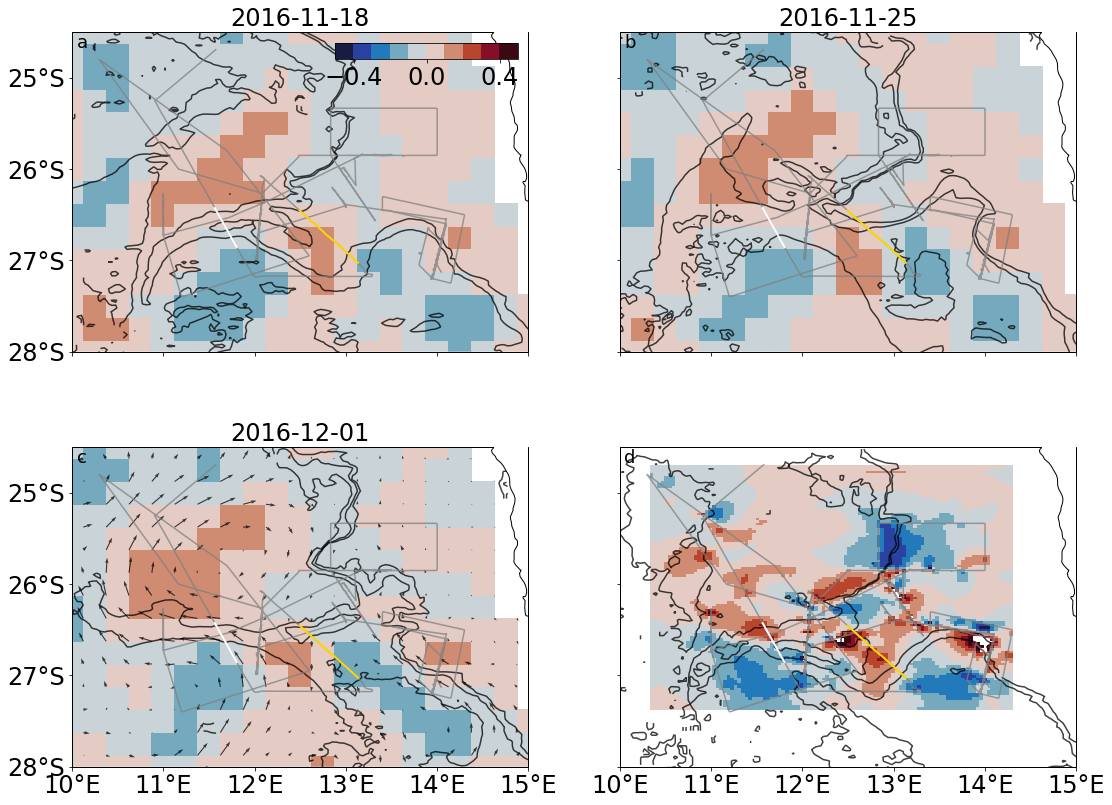

In [14]:
nrows, ncols =  2,2
projection = ccrs.PlateCarree()
x_y_lim = [10,16,-24.,-29]
x_y_lim = [10,15.,-24.5,-28.]

fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*9.,nrows*7),subplot_kw=dict(projection=projection))
axs = axs.ravel()
si = 0
dataset = cfeature.NaturalEarthFeature(category='physical', name='land', scale='10m')

# loop through the 3 SSH based Ro maps, and the ADCP Ro map
for ttime in Ro_all.time.isel(time=slice(0,4)):
    # ====== Ro from SSH and ADCP data
    if ttime == Ro_all.time[-3]:
        # adding higher resolution Ro from ADCP; Ro_all is a coarse version
        Ro_krig.plot(x='lon_left',y='lat_left',transform=projection,vmin=-0.5,vmax=0.5,levels=11,cmap=cmo.balance,
                    ax=axs[si],add_colorbar=False,robust=True,extend='neither')
    else:
        p = Ro_all.sel(time=ttime).plot(transform=projection,vmin=-0.5,vmax=0.5,levels=11,cmap=cmo.balance,
                    add_colorbar=False, robust=True,ax=axs[si],extend='neither') 
    
    axs[si].add_feature(dataset, zorder=100, edgecolor='k', facecolor = 'w')
    if ttime==Ro_all.time[2]:
        # add Geostrophic current vectors
        lon2, lat2 = np.meshgrid(gos_map.sel(time=ttime,lon=slice(8,17),lat=slice(-30,-22)).lon.values,
                                 gos_map.sel(time=ttime,lon=slice(8,17),lat=slice(-30,-22)).lat.values)
        gos_plt = axs[si].quiver(lon2, lat2, gos_map.sel(time=ttime,lon=slice(8,17),lat=slice(-30,-22)).ugos.values,
                            gos_map.sel(time=ttime,lon=slice(8,17),lat=slice(-30,-22)).vgos.values , transform=projection,
                                alpha=0.75)#,scale=700)
    # show ship track
    (sadcp.sel(z=z_sel,method='nearest').sel(time=t_slice).set_coords(['lon']).lat.plot(x='lon',color='0.5',lw=1.5,alpha=0.75,
                                                                                        ax=axs[si], transform=projection))
    # and scanfish transects
    scan_sadcp_transects_1km_filament['ScanTransect1'].lat.plot(x='lon',lw = 2, color='w', 
                                                                transform=projection,ax=axs[si],zorder=100)
    scan_sadcp_transects_1km_filament['ScanTransect2'].lat.plot(x='lon',lw = 2, color=color4, 
                                                                transform=projection,ax=axs[si],zorder=100)

    axs[si]=setup_cartopy_ticks(axs[si])
    # set axis limits
    axs[si].set_extent(x_y_lim, projection)
        
    if ttime == Ro_all.time[0]:
        # add colorbar
        mappable = axs[si].collections[0]
        cbaxes = inset_axes(axs[si], width="40%", height="5%", loc=1) 
        plt.colorbar(mappable, cax=cbaxes, orientation='horizontal', ticks=np.linspace(-0.4,0.4,3))
    
    # add filament sst contour; 17 and 18 work well (since SST warms over study period), but need 16.5 to link to transects
    sst_map_ds.sst.sel(Date=ttime,method='nearest').plot.contour(levels=np.array((16.5,17,18)),ax=axs[si], transform=projection,
                                                                          colors='k',linewidths=1.5,alpha=0.75)
    axs[si].set_ylabel('')
    axs[si].set_xlabel('')
    if ttime == Ro_all.time[-3]:
        axs[si].set_title('')
    else:
        axs[si].set_title(ttime.dt.strftime("%Y-%m-%d").values)
    if (si % 2) != 0:
        axs[si].set_yticklabels('')
    if si < 2:
        axs[si].set_xticklabels('')
    axs[si].set_rasterized(True) # !! to reduce file size make this image, rest stays vectors
    si = si+1

plt.tight_layout() # squeeze subplots together
label_axes(fig,labels=np.array(('a','b','c','d','','')),loc=(0.01,0.95),size=18)

figname = figure_dir+'Figure_maps_Ro_from_SSH_SADCP.pdf'
fig.savefig(figname, orientation='landscape', bbox_inches='tight')


#####    3. Rossby number map - drifter


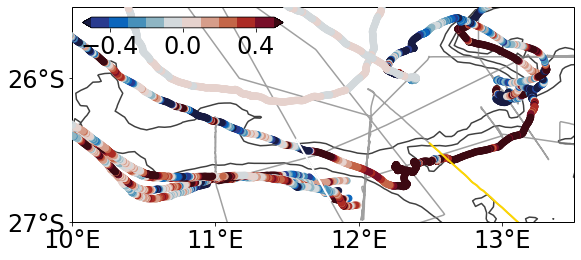

In [13]:
nrows, ncols =  1,1
projection = ccrs.PlateCarree()
x_y_lim = [10,16,-24.,-29]
x_y_lim = [10,15.,-24.5,-28.]
x_y_lim = [10,13.5,-25.5,-27.]

fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*9.,nrows*7),subplot_kw=dict(projection=projection))
si = 0

dataset = cfeature.NaturalEarthFeature(category='physical', name='land', scale='10m')

# Ro from drifter as scatter plot; applying some smoothing (running mean) as there is too much data to view
(drifter_Ro_clean.sel(calc_method='Triangle').isel(drifter_release=slice(0,2)).rolling(time=12,center=True,min_periods=6).mean(skipna=True).
 plot.scatter(x='lon_res',y='lat_res',hue='RossbyNumber',s=40, zorder=20,transform=projection,
              vmin=-0.5,vmax=0.5,levels=11,cmap=cmo.balance,ax=axs,add_guide=False,robust=True,rasterized=True))

axs.add_feature(dataset, zorder=100, edgecolor='k', facecolor = 'w')
# show ship track
(sadcp.sel(z=z_sel,method='nearest').sel(time=t_slice).set_coords(['lon']).lat.plot(x='lon',color='0.5',lw=1.5,alpha=0.75,
                                                                                    ax=axs, transform=projection))
# and scanfish transects
scan_sadcp_transects_1km_filament['ScanTransect1'].lat.plot(x='lon',lw = 2, color='w', 
                                                            transform=projection,ax=axs,zorder=100)
scan_sadcp_transects_1km_filament['ScanTransect2'].lat.plot(x='lon',lw = 2, color=color4, 
                                                            transform=projection,ax=axs,zorder=100)

axs=setup_cartopy_ticks(axs)
# set axis limits
axs.set_extent(x_y_lim, projection)
# add colorbar
mappable = axs.collections[0]
cbaxes = inset_axes(axs, width="40%", height="5%", loc=2) 
plt.colorbar(mappable, cax=cbaxes, orientation='horizontal', ticks=np.linspace(-0.4,0.4,3))
    
# add filament sst contour; choosing later data to better match drifter path
sst_map_ds.sst.sel(Date=Ro_all.time[2],method='nearest').plot.contour(levels=np.array((16.5,17,18)),ax=axs, transform=projection,
                                                                      colors='k',linewidths=1.5,alpha=0.75)
axs.set_ylabel('')
axs.set_xlabel('')
axs.set_title('')
#axs.set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

figname = figure_dir+'Figure_map_Ro_from_drifter_zoom.pdf'
fig.savefig(figname, orientation='landscape', bbox_inches='tight')


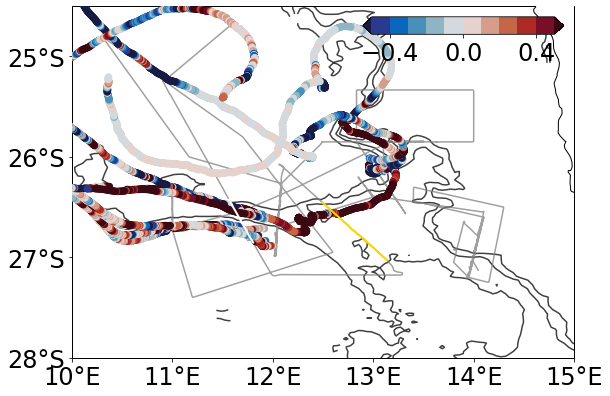

In [16]:
nrows, ncols =  1,1
projection = ccrs.PlateCarree()
x_y_lim = [10,16,-24.,-29]
x_y_lim = [10,15.,-24.5,-28.]

fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*9.,nrows*7),subplot_kw=dict(projection=projection))
si = 0

dataset = cfeature.NaturalEarthFeature(category='physical', name='land', scale='10m')

# Ro from drifter as scatter plot; applying some smoothing (running mean) as there is too much data to view
(drifter_Ro_clean.sel(calc_method='Triangle').rolling(time=12,center=True,min_periods=6).mean(skipna=True).
 plot.scatter(x='lon_res',y='lat_res',hue='RossbyNumber',s=40, zorder=20,transform=projection,
              vmin=-0.5,vmax=0.5,levels=11,cmap=cmo.balance,ax=axs,add_guide=False,robust=True))

axs.add_feature(dataset, zorder=100, edgecolor='k', facecolor = 'w')
# show ship track
(sadcp.sel(z=z_sel,method='nearest').sel(time=t_slice).set_coords(['lon']).lat.plot(x='lon',color='0.5',lw=1.5,alpha=0.75,
                                                                                    ax=axs, transform=projection))
# and scanfish transects
scan_sadcp_transects_1km_filament['ScanTransect1'].lat.plot(x='lon',lw = 2, color='w', 
                                                            transform=projection,ax=axs,zorder=100)
scan_sadcp_transects_1km_filament['ScanTransect2'].lat.plot(x='lon',lw = 2, color=color4, 
                                                            transform=projection,ax=axs,zorder=100)

axs=setup_cartopy_ticks(axs)
# set axis limits
axs.set_extent(x_y_lim, projection)
# add colorbar
mappable = axs.collections[0]
cbaxes = inset_axes(axs, width="40%", height="5%", loc=1) 
plt.colorbar(mappable, cax=cbaxes, orientation='horizontal', ticks=np.linspace(-0.4,0.4,3))
    
# add filament sst contour; choosing later data to better match drifter path
sst_map_ds.sst.sel(Date=Ro_all.time[2],method='nearest').plot.contour(levels=np.array((16.5,17,18)),ax=axs, transform=projection,
                                                                      colors='k',linewidths=1.5,alpha=0.75)
axs.set_ylabel('')
axs.set_xlabel('')
axs.set_title('')
axs.set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

figname = figure_dir+'Figure_map_Ro_from_drifter.pdf'
fig.savefig(figname, orientation='landscape', bbox_inches='tight')
